In [1]:
import subprocess
import matplotlib.pyplot as plt
from collections import deque
import re
import time
from IPython import display
import numpy as np

def plot_gpu_utilization(y_min, refresh_seconds, num_bins):
    # Inicializa las listas para almacenar la utilización de la GPU y el tiempo
    gpu_utilization = deque(maxlen=num_bins)
    timestamps = deque(maxlen=num_bins)

    # Configura el gráfico
    fig, ax = plt.subplots()
    line1, = ax.plot([], [], 'r-')
    line2, = ax.plot([], [], 'b--')  # Línea para el promedio

    # Configura el eje y
    ax.set_ylabel('Utilización de GPU (%)')
    ax.set_yticks(np.arange(0, 101, 10))  # Ticks en incrementos de 10

    # Agrega una cuadrícula de fondo
    ax.grid(True, linestyle='--', alpha=0.5)

    start_time = time.time()  # Hora de inicio para normalizar los timestamps

    # Bucle infinito para actualizar el gráfico
    while True:
        # Ejecuta nvidia-smi y obtén la salida
        sp = subprocess.Popen(['nvidia-smi', '--query-gpu=utilization.gpu', '--format=csv,noheader,nounits'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        out_str = sp.communicate()
        out_list = out_str[0].decode('utf-8').split('\n')

        # Encuentra la utilización de la GPU y añádela a la lista
        m = re.search(r'(\d+)', out_list[0])
        if m is not None:
            gpu_util = int(m.group(1))
            gpu_utilization.append(gpu_util)
        else:
            print("No match found in nvidia-smi output.")  # Debugging line

        # Añade el timestamp actual a la lista (normalizado a la hora de inicio)
        timestamps.append(time.time() - start_time)

        # Calcula el promedio de los valores de gpu_utilization
        gpu_utilization_avg = np.mean(gpu_utilization)

        # Crea una lista con el valor promedio repetido para cada timestamp
        gpu_utilization_avg_line = [gpu_utilization_avg] * len(timestamps)

        # Update y-axis limits based on last num_bins values
        # Actualiza los límites del eje y basándose en los últimos valores de num_bins
        if len(gpu_utilization) == num_bins:  
            y_max = max(gpu_utilization)
            ax.set_ylim(y_min, y_max)
        # Actualiza el gráfico
        line1.set_xdata(timestamps)
        line1.set_ydata(gpu_utilization)
        line2.set_xdata(timestamps)
        line2.set_ydata(gpu_utilization_avg_line)

        # Actualiza los límites del eje y basándose en los últimos valores de num_bins
        if len(gpu_utilization) == num_bins:  
            y_max = max(gpu_utilization)
            ax.set_ylim(y_min, y_max)

        ax.relim()
        ax.autoscale_view(True, True, True)

        # Elimina todas las anotaciones existentes
        for txt in ax.texts:
            txt.set_visible(False)

        # Añade las anotaciones a los puntos cada 10 segundos y al último punto
        for i, value in enumerate(gpu_utilization):
            if i % 10 == 0 or i == len(gpu_utilization) - 1:  
                ax.text(timestamps[i], value, f"{value}%")

        # Limpiar y mostrar la figura
        display.clear_output(wait=True)
        display.display(plt.gcf())

        # Espera el número de segundos especificado antes de actualizar de nuevo
        time.sleep(refresh_seconds)




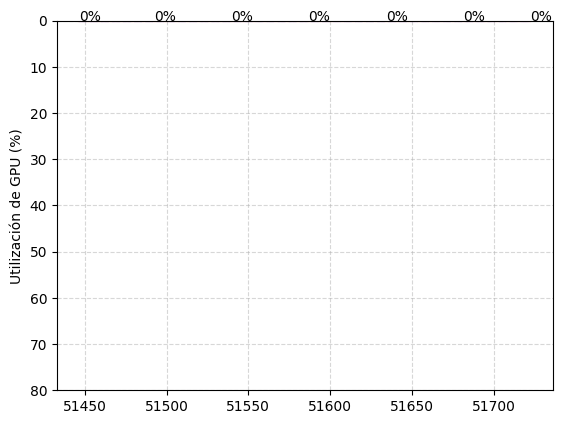

In [ ]:
plot_gpu_utilization(y_min=80, refresh_seconds=1, num_bins=60)